In [1]:
import scanpy as sc
import pandas as pd
from pathlib import Path
import anndata as ad
import numpy as np
import os
import scvi

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

DPI = 300
FONTSIZE = 20  # 42

sc.settings.set_figure_params(
    scanpy=True, dpi=100, transparent=True, vector_friendly=True, dpi_save=DPI
)
from matplotlib import rcParams

rcParams["pdf.fonttype"] = 42

Global seed set to 0


In [2]:
DIR2LOAD = Path(
    "/data/BCI-CRC/nasrine/data/CRC/Primary_CRC_dataset/subpopulations/Endothelial/"
)

In [3]:
DIR2SAVE = DIR2LOAD.joinpath("final/")
DIR2SAVE.mkdir(parents=True, exist_ok=True)

In [4]:
FIG2SAVE = DIR2SAVE.joinpath("figures/")
FIG2SAVE.mkdir(parents=True, exist_ok=True)
# set the global variable: sc.settings.figdir to save all plots
sc.settings.figdir = FIG2SAVE

In [5]:
adata = sc.read_h5ad(
    DIR2LOAD.joinpath(
        "SMC_KUL_Pelka_Che_Wu_CRC_integrated_scvi_hvg_Endothelial_clustering.h5ad"
    )
)

In [6]:
set(adata.obs.Annotation_scVI_detailed)

{'Doublet',
 'Endo cycling',
 'Lymphatic endo',
 'Myeloid-stromal doublet',
 'Stalk-like endo',
 'T-endo doublet',
 'Tip-like endo'}

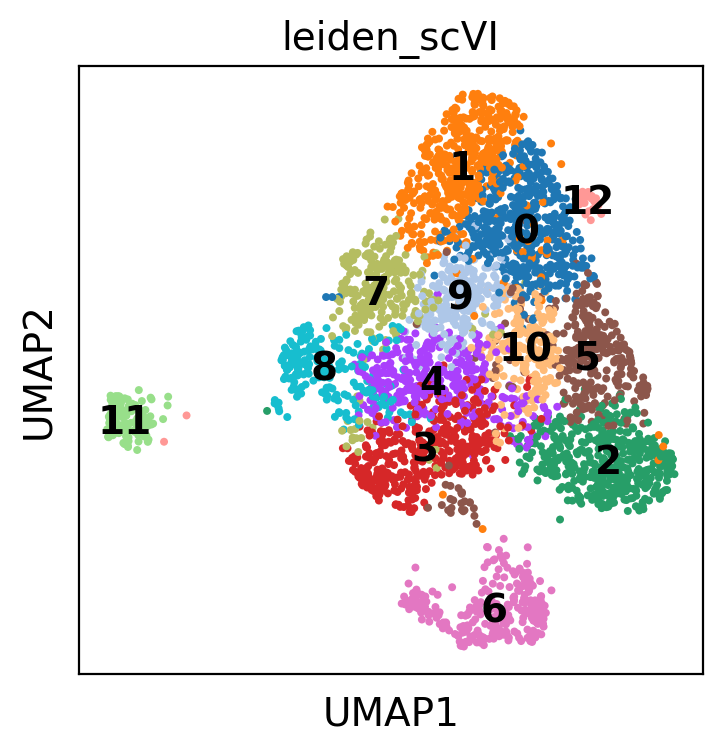

In [7]:
sc.pl.umap(
    adata,
    color="leiden_scVI",
    legend_loc="on data",
    show=True,
    save="leiden_before_removal_problem_clusters.pdf",
)

### Remove problem clusters 

In [8]:
set(
    adata[
        ~adata.obs.Annotation_scVI_detailed.isin(
            ["Doublet", "Myeloid-stromal doublet", "T-endo doublet"]
        )
    ].obs.Annotation_scVI_detailed
)

{'Endo cycling', 'Lymphatic endo', 'Stalk-like endo', 'Tip-like endo'}

In [9]:
adata = adata[
    ~adata.obs.Annotation_scVI_detailed.isin(
        ["Doublet", "Myeloid-stromal doublet", "T-endo doublet"]
    )
].copy()

In [10]:
adata

AnnData object with n_obs × n_vars = 3051 × 2000
    obs: 'Patient', 'Sample', 'Cell_type', 'Cell_subtype', 'Tissue', 'Therapy', 'doublet_score', 'predicted_doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'cell_source', '_scvi_batch', '_scvi_labels', 'leiden_scVI', 'S_score', 'G2M_score', 'phase', 'cell_cycle_diff', 'Annotation_scVI_detailed'
    var: 'n_cells_by_counts-Che', 'total_counts-Che', 'mean_counts-Che', 'pct_dropout_by_counts-Che', 'n_cells_by_counts-KUL', 'total_counts-KUL', 'mean_counts-KUL', 'pct_dropout_by_counts-KUL', 'n_cells_by_counts-Pelka', 'total_counts-Pelka', 'mean_counts-Pelka', 'pct_dropout_by_counts-Pelka', 'n_cells_by_counts-SMC', 'total_counts-SMC', 'mean_counts-SMC', 'pct_dropout_by_counts-SMC', 'n_cells_by_counts-Wu', 'total_counts-Wu', 'mean_counts-Wu', 'pct_dropout_by_counts-Wu', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_

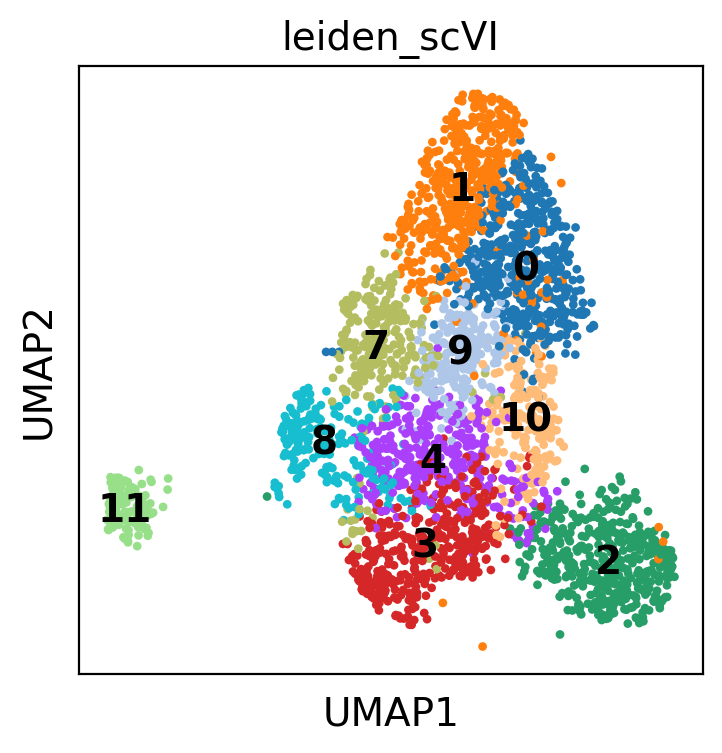

In [11]:
sc.pl.umap(
    adata,
    color="leiden_scVI",
    legend_loc="on data",
    show=True,
    save="leiden_after_removal_problem_clusters.pdf",
)

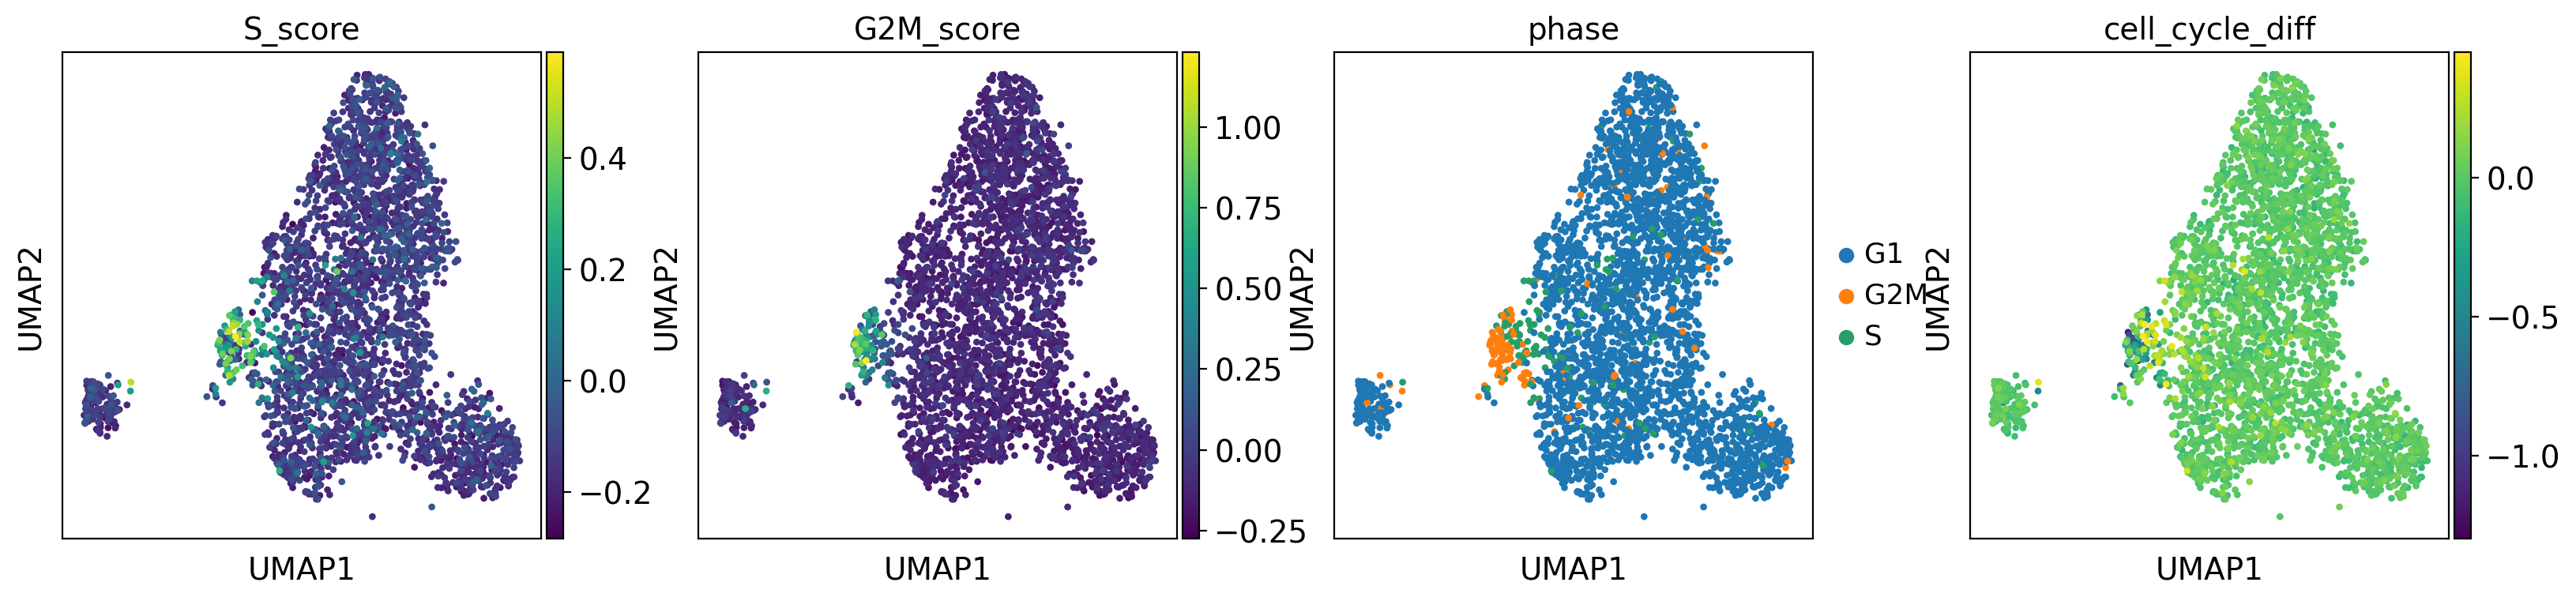

In [12]:
sc.pl.umap(
    adata,
    color=["S_score", "G2M_score", "phase", "cell_cycle_diff"],
    color_map="viridis",
    save="cell_cycle.pdf",
)

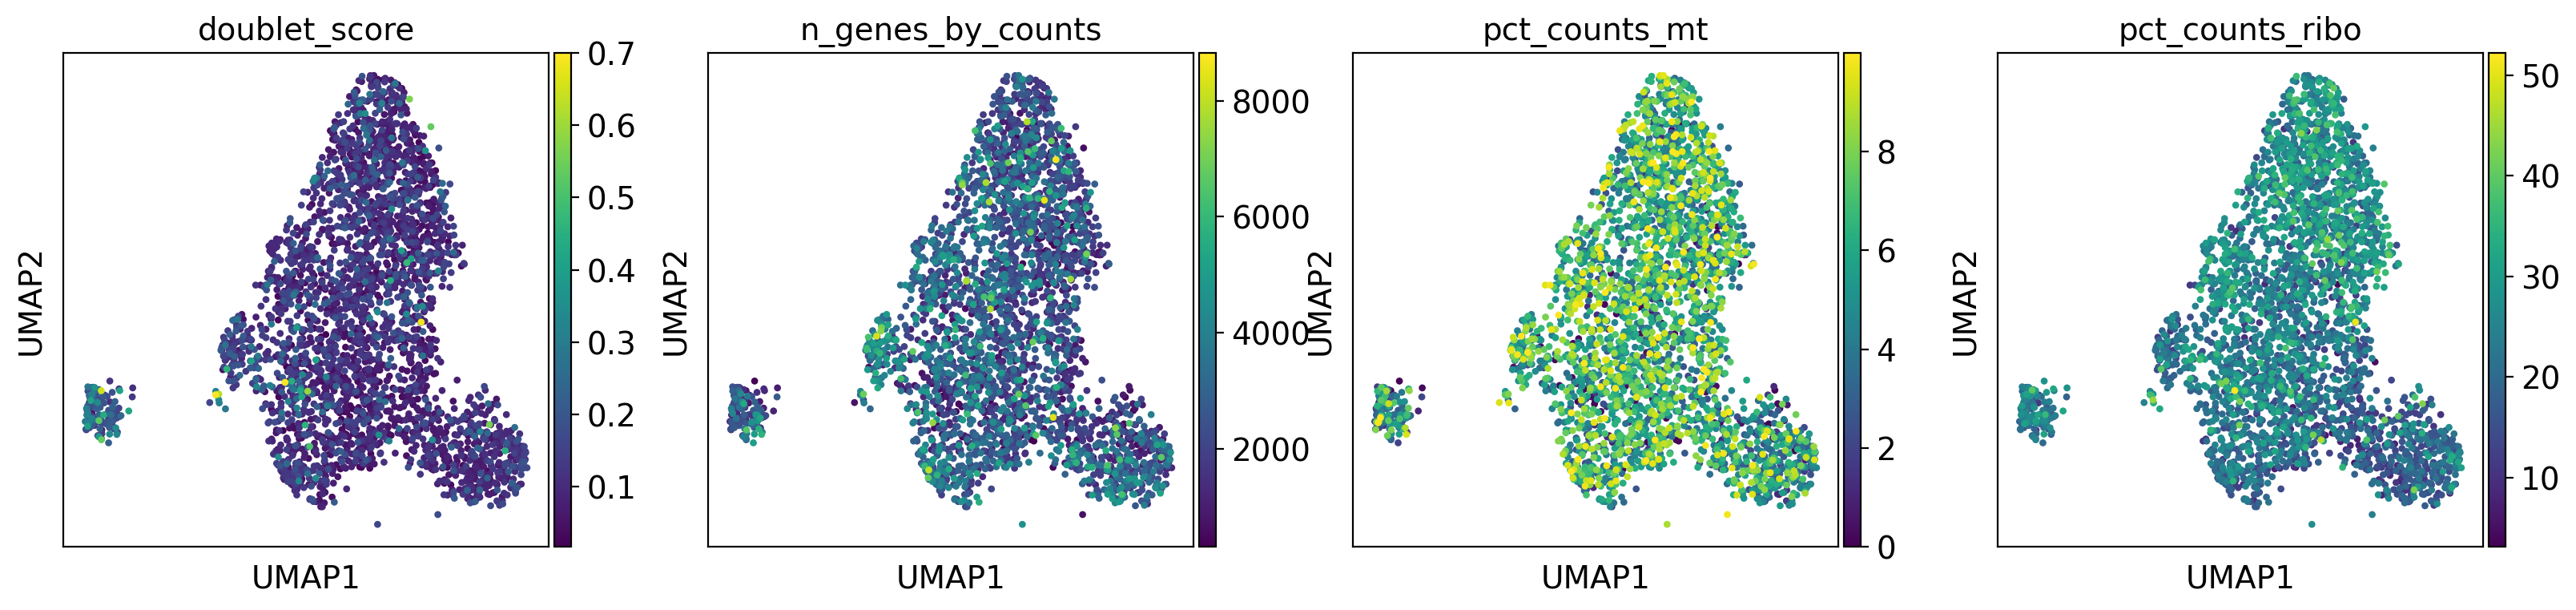

In [13]:
sc.pl.umap(
    adata,
    color=["doublet_score", "n_genes_by_counts", "pct_counts_mt", "pct_counts_ribo"],
    color_map="viridis",
    save="QC_covariates.pdf",
)

### Look at distribution of cell source across clusters 

In [14]:
from matplotlib.patches import Rectangle


def proportion_cells_patient(
    adata, groupby_labels, xlabel: str, ylabel: str, colors: dict, figname: str
):  # colors
    # compute proportion of cells within each group
    table2plot = (
        adata.reset_index()
        .groupby(groupby_labels)
        .size()
        .groupby(level=0)
        .apply(lambda x: x * 100 / x.sum())
        .unstack()
    )

    fig, ax = plt.subplots(
        nrows=1,
        ncols=1,
        sharey=False,
        sharex=False,
        dpi=DPI,
    )  # figsize=(4, 4))

    print(table2plot)
    table2plot.plot.bar(stacked=True, ax=ax, color=colors.values())  # , color=colors
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    ax.grid(False, which="major", axis="both")  # removes major horizontal gridlinesd

    labels = list(colors.keys())
    l = [Rectangle((0, 0), 0, 0, color=color) for color in list(colors.values())]
    ax.legend(
        l,
        labels,
        loc="upper left",
        bbox_to_anchor=(1, 0.8),
        facecolor="white",
        edgecolor="white",
        ncol=1,
        borderaxespad=0.0,
        framealpha=0,
        frameon=False,
    )

    plt.savefig(FIG2SAVE.joinpath(figname), dpi=DPI, format="pdf", bbox_inches="tight")
    plt.show()

cell_source        SMC        KUL      Pelka        Che
leiden_scVI                                            
0            17.161017  18.220339  60.593220   4.025424
1            13.390929  11.879050  70.410367   4.319654
2            20.990566  12.028302  63.207547   3.773585
3            18.481013  12.151899  67.848101   1.518987
4            21.806854  12.149533  63.862928   2.180685
7            30.578512  10.330579  57.024793   2.066116
8            25.000000   3.240741  71.296296   0.462963
9            26.341463  15.609756  51.707317   6.341463
10           12.903226  19.354839  53.225806  14.516129
11           20.472441  24.409449  21.259843  33.858268


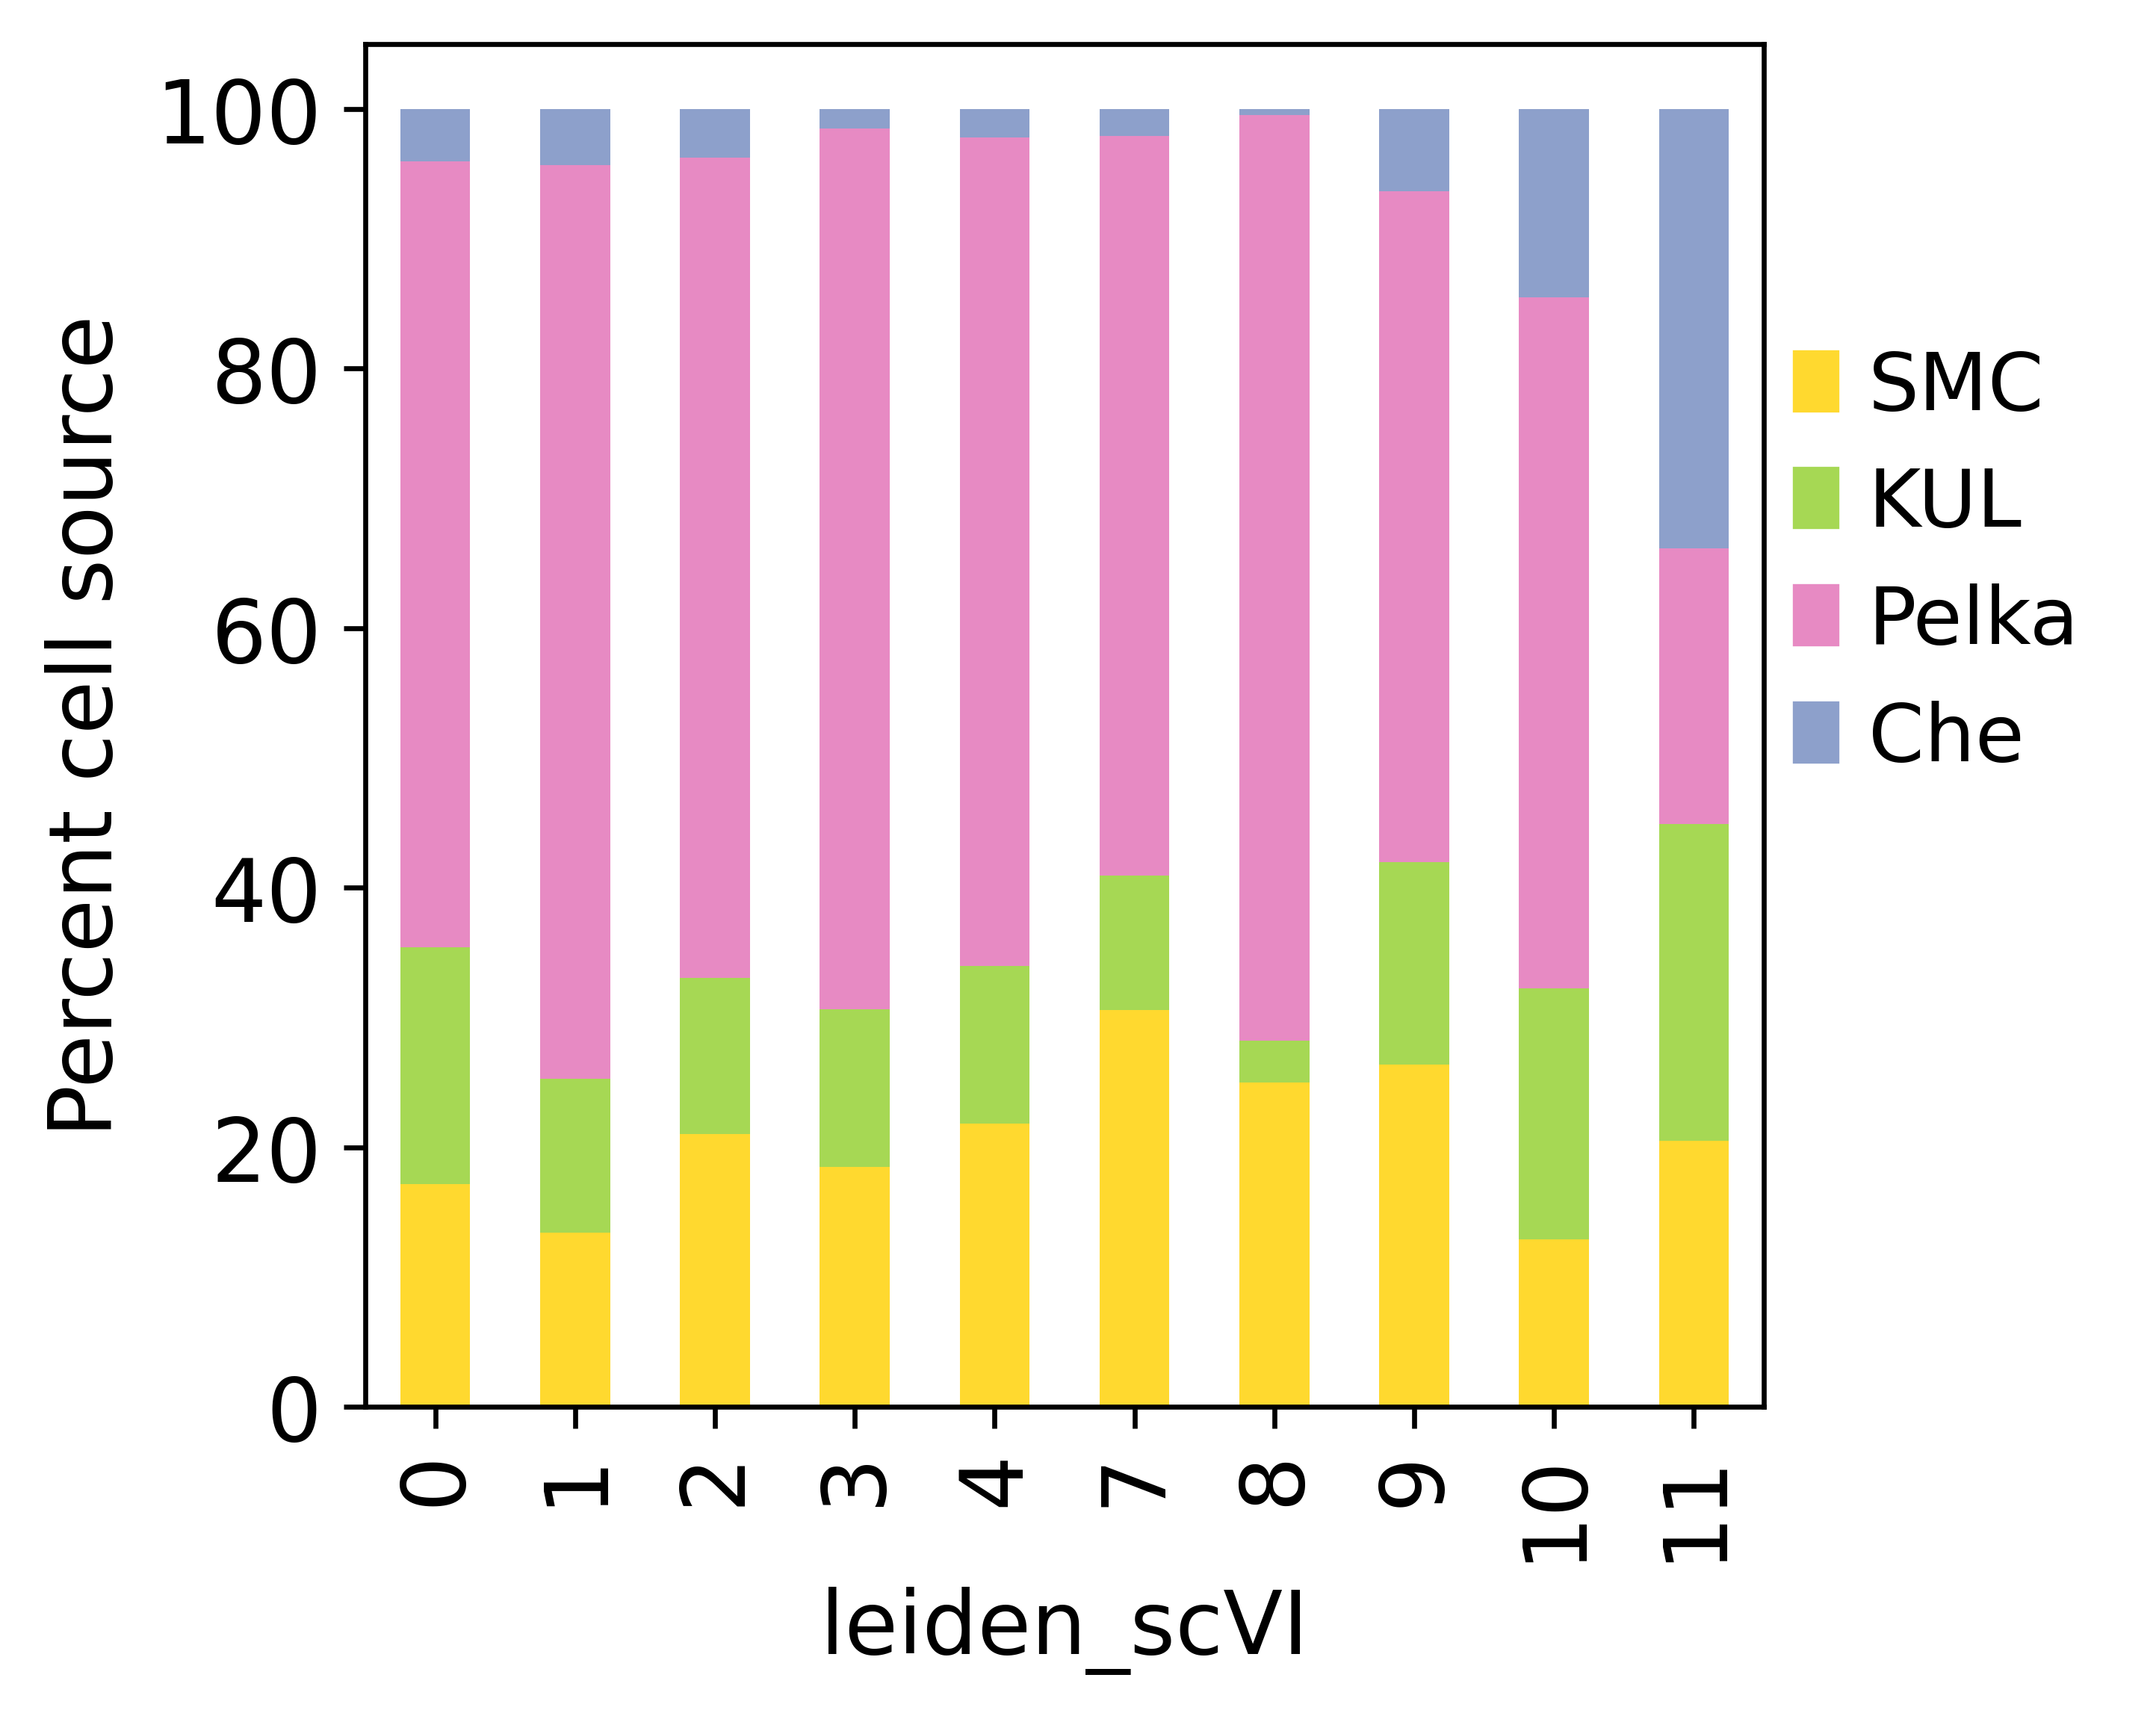

In [15]:
from collections import OrderedDict

color_dict = OrderedDict(
    zip(
        adata.obs["cell_source"].cat.categories.values.tolist(),
        adata.uns["cell_source_colors"],
    )
)

proportion_cells_patient(
    adata.obs,
    groupby_labels=["leiden_scVI", "cell_source"],
    xlabel="leiden_scVI",
    ylabel="Percent cell source",
    colors=color_dict,
    figname="leiden_cell_source.pdf",
)

In [16]:
markers = {
    "Endo": ["PECAM1", "PLVAP"],
    "Lymphatic endo": ["LYVE1", "PROX1"],
    "Stalk": ["ACKR1", "SELP"],
    "Tip": ["RGCC", "KDR"],
    "Enteric glial": ["S100B", "PLP1"],
    "Prolif endo": ["BIRC5", "MKI67"],
    # "Arterial": ["EFNB2"],
}

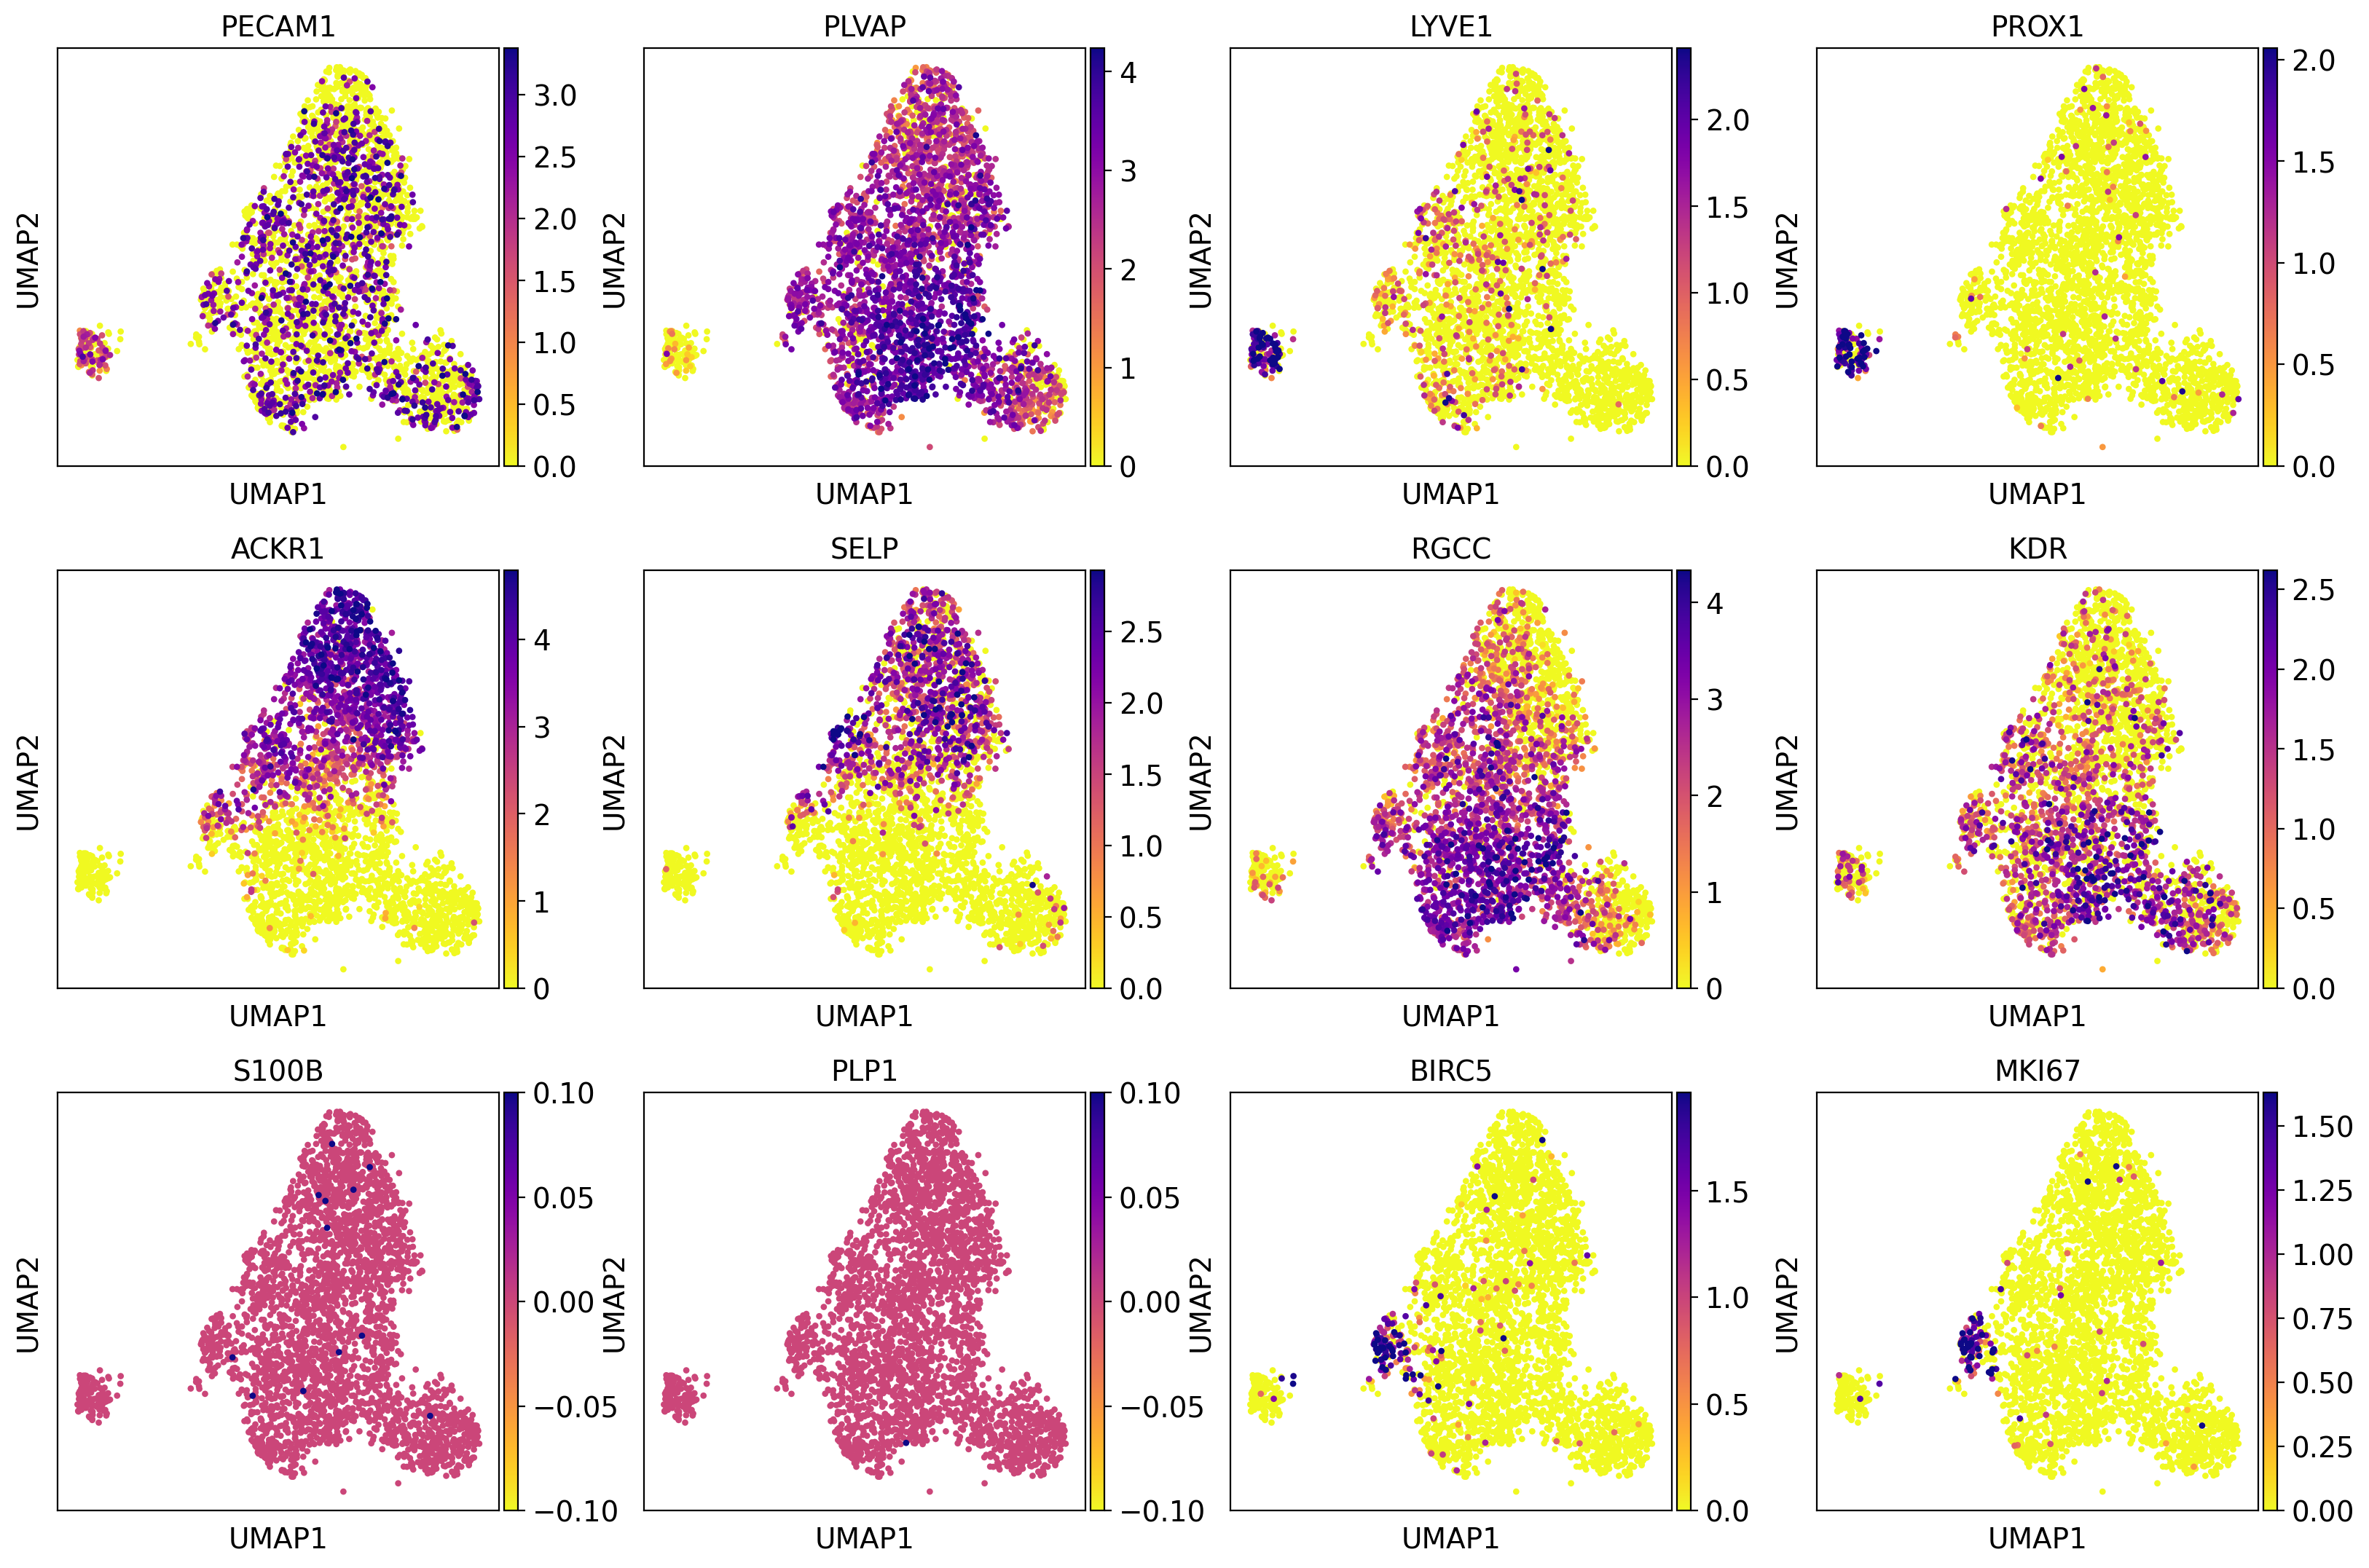

In [17]:
import itertools

# use log1p data stored in .raw
markers2plot = list(
    itertools.chain(*list(markers.values()))
)  # get all markers in a single list
sc.pl.umap(
    adata,
    color=markers2plot,
    use_raw=True,
    vmin=0.0,
    vmax="p99",
    color_map="plasma_r",  #'RdPu',
    save="general_markers.pdf",
    show=True,
)

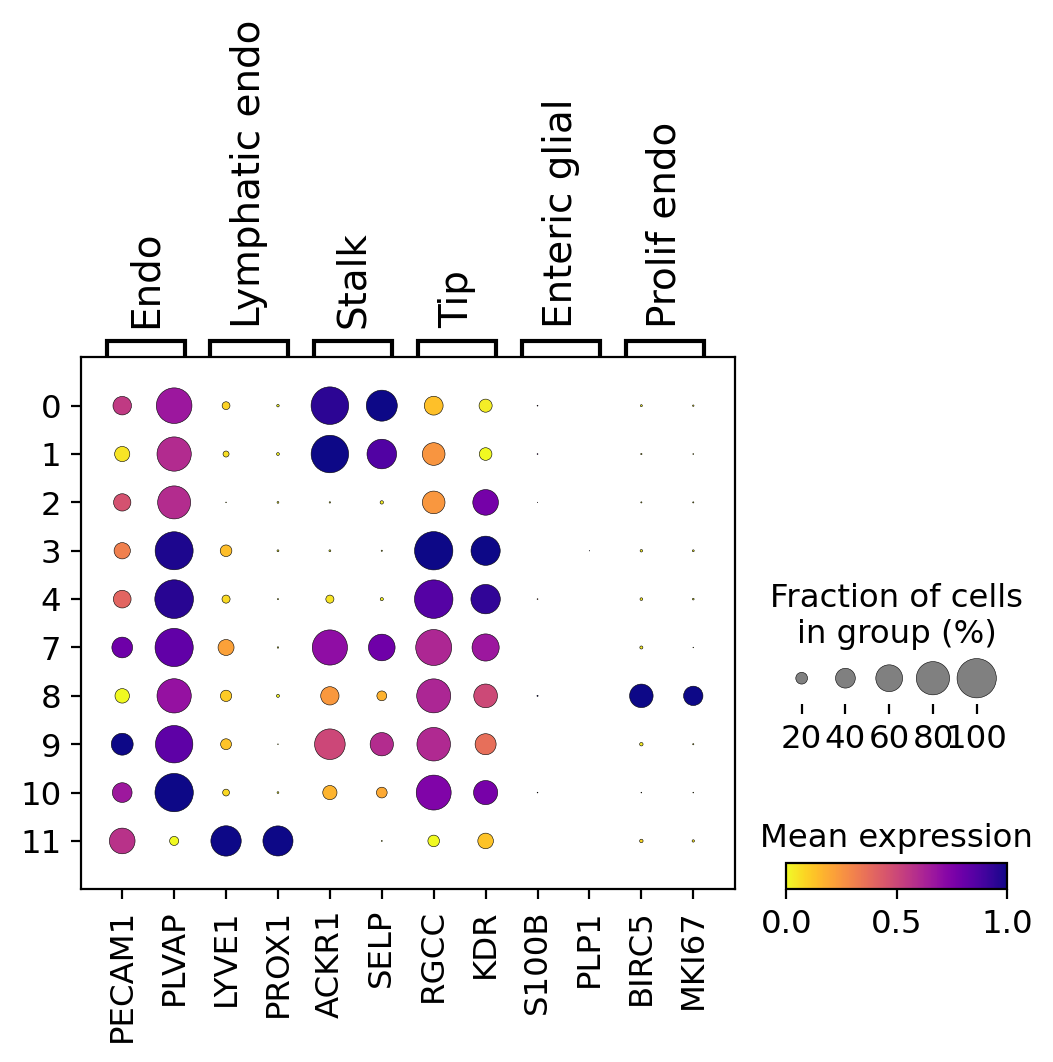

In [18]:
sc.pl.dotplot(
    adata,
    groupby="leiden_scVI",
    use_raw=True,
    var_names=markers,
    cmap="plasma_r",
    standard_scale="var",
    vmin=0,
    vmax=1,
    colorbar_title="Mean expression",
    dendrogram=False,
    save="Endothelial_dotplot_mean_general.pdf",
    show=True,
)

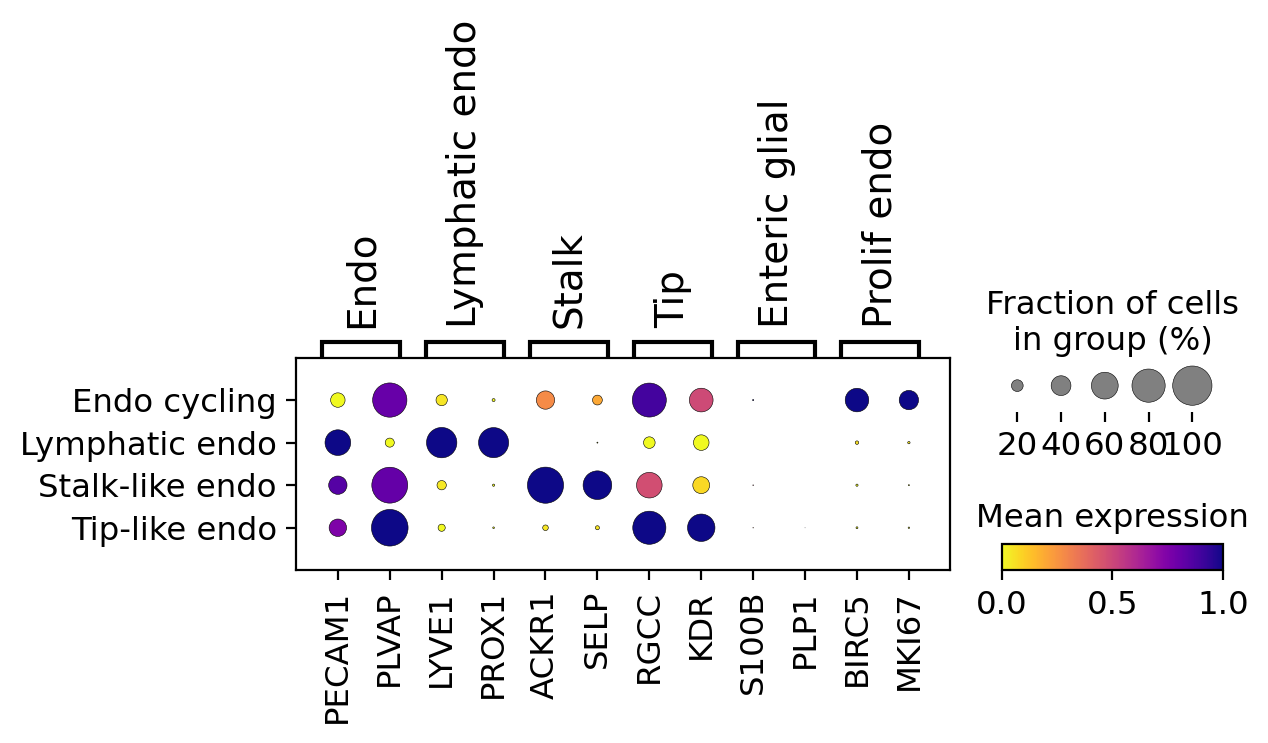

In [19]:
sc.pl.dotplot(
    adata,
    groupby="Annotation_scVI_detailed",
    use_raw=True,
    var_names=markers,
    cmap="plasma_r",
    standard_scale="var",
    vmin=0,
    vmax=1,
    colorbar_title="Mean expression",
    dendrogram=False,
    save="Endothelial_dotplot_mean_general_annotations.pdf",
    show=True,
)

### Change colours to match metastasis

In [7]:
# set colours for dataset, need to know order
adata.obs.Annotation_scVI_detailed.cat.categories.values.tolist()

['Endo cycling', 'Lymphatic endo', 'Stalk-like endo', 'Tip-like endo']

In [8]:
adata.uns["Annotation_scVI_detailed_colors"] = [
    "#fee391",
    "#e78ac3",
    "#8ae7ae", #"#66c2a5",
    "#ae8ae7", #"#fc8d62",
]

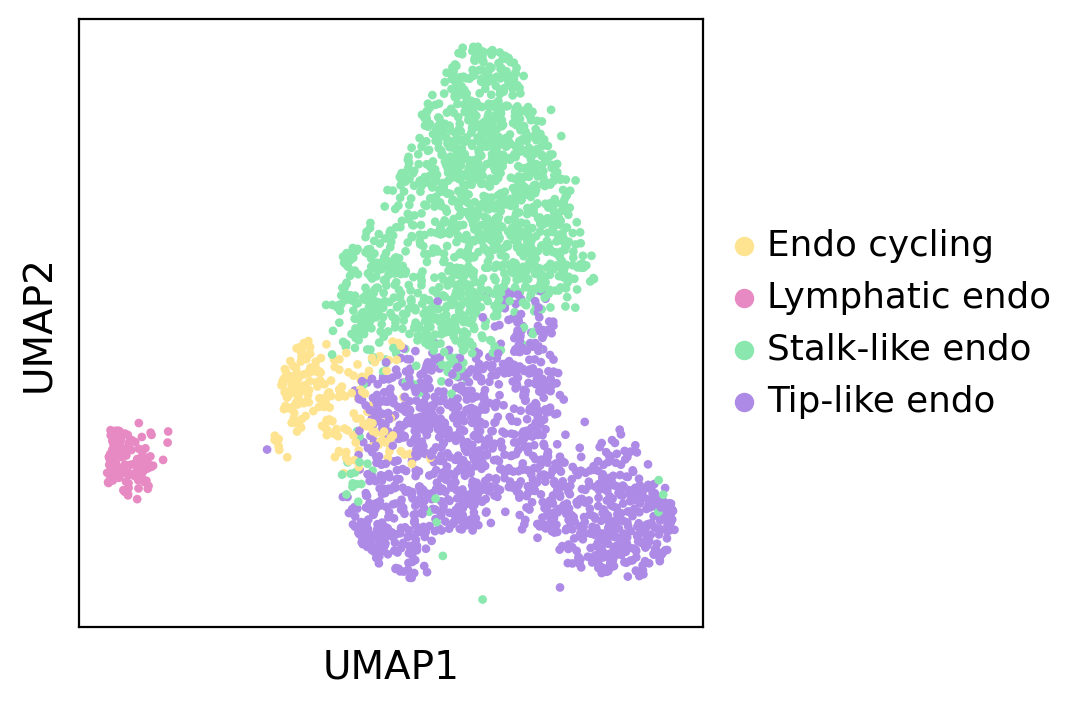

In [9]:
sc.pl.umap(
    adata,
    color="Annotation_scVI_detailed",
    show=True,
    legend_loc="right margin",
    save="Annotations.pdf",
    title="",
)

In [10]:
# save object
# write to file
adata.write(
    DIR2SAVE.joinpath(
        "SMC_KUL_Pelka_Che_Wu_CRC_integrated_scvi_hvg_Endothelial_final.h5ad"
    )
)

In [11]:
adata.shape

(3051, 2000)

In [12]:
adata.obs.Annotation_scVI_detailed.value_counts()

Stalk-like endo    1382
Tip-like endo      1326
Endo cycling        216
Lymphatic endo      127
Name: Annotation_scVI_detailed, dtype: int64

In [13]:
adata = sc.read_h5ad(
    DIR2SAVE.joinpath(
        "SMC_KUL_Pelka_Che_Wu_CRC_integrated_scvi_hvg_Endothelial_final.h5ad"
    )
)